In [6]:
############
#This program takes about 60 minutes to run
############

#Loading Package
import os

import time
import numpy as np
import scipy as sci
import scipy.io as sio
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras


from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt


import time



  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=76681dbe587eefb040aab41ed71f6fa6722aceefb13c073f18aa603308b7541a
  Stored in directory: c:\users\brand\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


In [12]:
# load raw data
raw = pd.read_csv(os.path.join('Implied_Volatility_Data_vFinal.csv'))
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
raw.head(n=5)

Size of the dataset (row, col):  (125700, 5)


,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,20140630,0.006678,0.184,0.745927,0.008462
1,20140630,0.006678,2.252,0.286911,0.002024
2,20140630,0.006678,0.124,0.902941,0.019707
3,20140630,0.006678,2.144,0.910926,0.006424
4,20140630,0.006678,1.412,0.885760,0.005673


## Construct the 3 variables for Regression Approach

In [13]:
# construct the 3 variables for regression
raw['x1'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year'])
raw['x2'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year']) * raw['Delta']
raw['x3'] = raw['x2'] * raw['Delta']

# Put the X and Y variable in data frame for regression
y = raw['Implied Volatility Change']
X = raw[['x1', 'x2', 'x3','SPX Return','Time to Maturity in Year','Delta']]

In [14]:
# Divide data into training set and test set(note that random seed is set)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

# Divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)

## Feature Scaling

In [15]:
# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

## Run Regression

In [16]:
# Run the regression on the training data
lr = LinearRegression(fit_intercept=False)
lr.fit(X_scaled_train[:,:3], y_train)

# Get the prediction
y_pred = lr.predict(X_scaled_test[:,:3])

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print('Test loss (MSE):', mse)

Test loss (MSE): 7.423167462421238e-05


## ML Approach

In [24]:
# Create ML Model
# Sequential function allows you to define your Neural Network in sequential order
# Within Sequential, use Dense function to define number of nodes, activation function and other related parameters 
# For more information regrading to activation functoin, please refer to https://keras.io/activations/
model = keras.models.Sequential([Dense(10,activation = "sigmoid",input_shape = (3,)),
                                 Dense(10,activation = "sigmoid"),Dense(10,activation = "sigmoid"),
                                Dense(1)])

# Model summary function shows what you created in the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                40        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Complie function allows you to choose your measure of loss and optimzer
# For other optimizer, please refer to https://keras.io/optimizers/
model.compile(loss = "mse",optimizer = "Adam")

In [19]:
# Checkpoint function is used here to periodically save a copy of the model. 
# Currently it is set to save the best performing model
checkpoint_cb = keras.callbacks.ModelCheckpoint("implied_vol_model_vFinal.h5",save_best_only = True)

# Early stopping allows you to stop your training early if no improvment is shown after cerain period
# Currently it is set at if no improvement occured in 1000 epochs, at the stop the model will also revert back to the best weight
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1000,restore_best_weights = True)

# Remark: checkpoint could be redundant here as early stopping function can also help restoring to the best weight
# We put both here just to illustrate different ways to keep the best model
 

In [20]:
# train your model
# The fit function allows you to train a NN model. Here we have training data, number of epochs,batch size, validation data, 
# and callbacks as input
# Callback is an optional parameters that allow you to enable tricks for training such as early stopping and checkpoint

# Remarks: Altough we put 50000 epochs here, the model will stop its training once our early stopping criterion is triggered





start = time.time()
history=model.fit(X_scaled_train[:,3:6],y_train,epochs=50000, batch_size = 128, verbose = 0, validation_data=(X_scaled_vals[:,3:6],y_val),
                 callbacks=[checkpoint_cb, early_stopping_cb])
end = time.time()
print(end - start)


4046.279750585556


In [21]:
# Load the best model you saved and calcuate MSE for testing set

model = keras.models.load_model("implied_vol_model_vFinal.h5")
mse_test = model.evaluate(X_scaled_test[:,3:6],y_test,verbose=0)

print('Test Loss(MSE):', mse_test)

Test Loss(MSE): 6.384313746821135e-05


In [22]:
# Calculate Gain Ratio

gain = 1 - mse_test/mse 

print('Gain Ratio:', gain)

Gain Ratio: 0.13994749826932462


## Review your results and export training history


In [25]:
#Export your training history for MSE
output = pd.DataFrame(history.history)
output.to_csv("mse_overtime.csv", index = False)

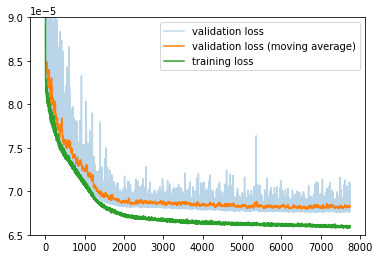

In [26]:
# Plot training history

df = pd.read_csv('mse_overtime.csv')

plt.plot(np.arange(len(df)), df['val_loss'], alpha = 0.3, label='validation loss')
plt.plot(np.arange(len(df)), df['val_loss'].rolling(25).mean(), label='validation loss (moving average)')
plt.plot(np.arange(len(df)), df['loss'], label='training loss')

plt.legend()
plt.ylim(0.000065,0.00009)
#plt.savefig('mse.png',bbox_inches='tight', transparent=True, dpi=300) 


plt.show()